In [1]:
from contextlib import suppress

import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from pathlib import Path

from requests import get, Response
from hashlib import sha256
from tqdm.notebook import tqdm
from zipfile import ZipFile
from IPython.display import display, Markdown
import pandas as pd
from utils.image_inverter import save as save
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# For pretty writing
from IPython.display import display, Markdown


# Analyse exploratoire de données (Exploratory Data Analysis)


## Partie 0 - Outils

In [2]:


graph_folder: Path = Path("./graphs")


def save_figure(figure: plt.Figure, folder: str, figure_name: str) -> None:
    folder = graph_folder / folder
    folder.mkdir(parents=True, exist_ok=True)
    save(figure, folder / f'{figure_name}.png')


_cache_folder = Path('~/.cache/gn_p7').expanduser()
_cache_folder.mkdir(parents=True, exist_ok=True)

_ds_url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip'


def download(url: str) -> Path:
    url_id: str = sha256(url.encode('utf-8')).hexdigest()
    local_path: Path = _cache_folder / url_id
    local_path.parent.mkdir(parents=True, exist_ok=True)
    if not local_path.exists():
        tmp_path: Path = _cache_folder / (url_id + '.tmp')
        res: Response = get(url, stream=True)
        with tmp_path.open('wb') as f, tqdm(
                total=int(res.headers.get('content-length')),
                desc=f'Downloading {url}',
                unit_scale=True) as q:
            for chunk in res.iter_content(chunk_size=8192):
                q.update(len(chunk))
                f.write(chunk)
        tmp_path.replace(local_path)
    return local_path


def download_zip_archive(url: str) -> Path:
    """Download a zip archive, extract it then return the folder containing its content"""
    archive_path: Path = download(url)
    archive_folder: Path = Path(archive_path.as_posix() + '.dir')

    if not archive_folder.exists():
        print(f'Extracting archive {url}...', flush=True)
        archive_temp: Path = Path(archive_path.as_posix() + '.tmp')
        archive_temp.mkdir(parents=True, exist_ok=True)
        archive: ZipFile = ZipFile(archive_path)
        archive.extractall(path=archive_temp)
        archive_temp.replace(archive_folder)
        print(f'Extracting archive {url}...done', flush=True)

    return archive_folder


datasets: dict[str, pd.DataFrame] = {}


def get_dataset(name: str) -> pd.DataFrame:
    folder = download_zip_archive(_ds_url)
    if not name.endswith('.csv'):
        name = f'{name}.csv'
    try:
        return datasets[name]
    except KeyError:
        try:
            _df = pd.read_csv(folder / name)
        except FileNotFoundError:
            display(Markdown(f'# ERROR: Dataset {name!r} not found, available datasets are:\n' + '\n'.join(
                f'- {p.name}' for p in sorted(folder.iterdir(), key=(lambda x: x.name.lower())))))
            raise KeyError(name) from None
        else:
            datasets[name] = _df
            return _df.copy()


## Partie 1 - Applications
Notre dataset contiens plusieurs fichiers.
Nous feront comme le notebook exemple, en commençant initialement avec application_{train,test}, puis en rajoutant des données pour améliorer la performance du modèle.

### Partie 1.1 - Données brutes

Il serai peut-être nécéssaire de prétraiter les données, cependant je vais tenter de créer un modèle initial sur les données brutes pour servir de référence

### 1.1.1 - k-Means

k-Means est linéaire, et non supervisé, il aura probablement un score assez faible

# WARNING: k-Means distinguish between two classes, but might switch classes

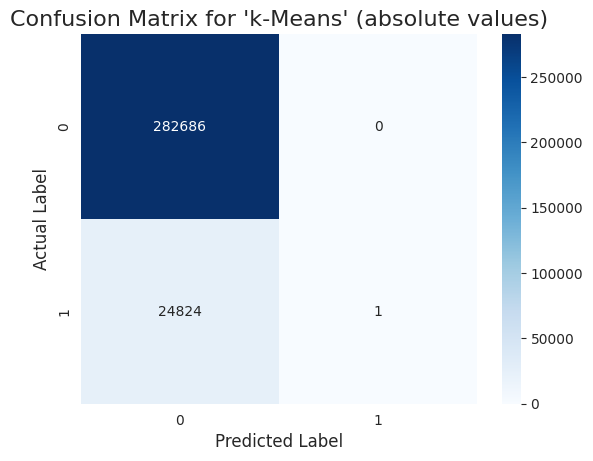

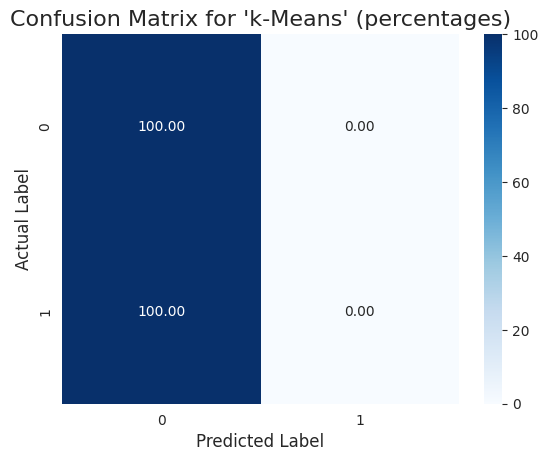

{'accuracy': 0.9192744324593266,
 'precision': 1.0,
 'recall': 4.028197381671702e-05,
 'f1_score': 8.05607024893257e-05}

In [3]:
# Scoring related



def heat_map(matrix: np.ndarray, classes: list[str], title: str, y_label: str, x_label: str, fmt: str) -> None:
    sns.heatmap(matrix, annot=True, fmt=fmt, xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title(title, fontsize=16)
    plt.ylabel(y_label, fontsize=12)
    plt.xlabel(x_label, fontsize=12)
    plt.show()

def confusion(
        y_truth: pd.Series,
        y_prediction: pd.Series,
        model_name: str,
) -> dict:
    assert len(y_truth) == len(y_prediction), "Input Series must have the same length."
    classes = sorted(set(y_truth) | set(y_prediction))
    matrix = confusion_matrix(y_truth, y_prediction, labels=classes)
    sns.heatmap(matrix / len(y_truth), annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name!r}', fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    return {
        # TODO: More metrics
        'accuracy': accuracy_score(y_truth, y_prediction),
        'precision': precision_score(y_truth, y_prediction, zero_division=0),
        'recall': recall_score(y_truth, y_prediction, zero_division=0),
        'f1_score': f1_score(y_truth, y_prediction, zero_division=0)
    }
def confusion(
        y_truth: pd.Series,
        y_prediction: pd.Series,
        model_name: str,
) -> dict:
    assert len(y_truth) == len(y_prediction), "Input Series must have the same length."
    classes = sorted(set(y_truth) | set(y_prediction))
    heat_map(
        (matrix := confusion_matrix(y_truth, y_prediction, labels=classes)),
        classes, f'Confusion Matrix for {model_name!r} (absolute values)', 'Actual Label', 'Predicted Label', 'd')

    # 'matrix' est la matrice de confusion non normalisée
    # On divise chaque valeur par la somme de sa ligne
    # np.newaxis est crucial pour que la division se fasse correctement
    heat_map(
        (100 * (matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis])),
        classes, f'Confusion Matrix for {model_name!r} (percentages)', 'Actual Label', 'Predicted Label', '.02f')

    return {
        # TODO: More metrics
        'accuracy': accuracy_score(y_truth, y_prediction),
        'precision': precision_score(y_truth, y_prediction, zero_division=0),
        'recall': recall_score(y_truth, y_prediction, zero_division=0),
        'f1_score': f1_score(y_truth, y_prediction, zero_division=0)
    }


def k_means():
    display(Markdown('# WARNING: k-Means distinguish between two classes, but might switch classes'))
    X = get_dataset('application_train.csv')
    y_true = X.pop('TARGET')
    for column in list(X.columns):
        try:
            X[column] = X[column].astype(float).fillna(0)
        except ValueError:
            X.pop(column)
    model = KMeans(len(y_true.unique()))
    y_pred = model.fit(X).predict(X)
    return confusion(y_true, y_pred, 'k-Means')


k_means()

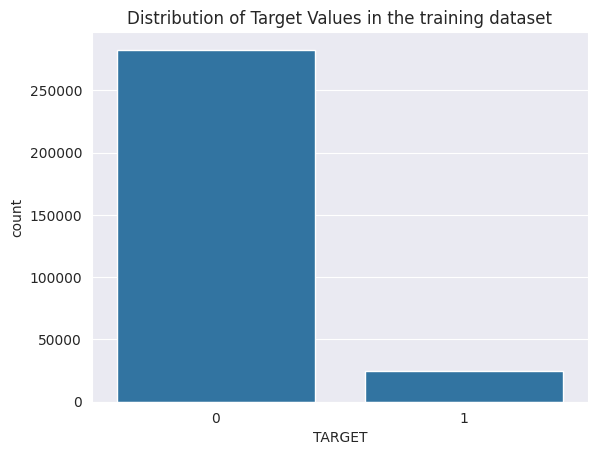

<b>Nous pouvons voir ici un clair déséquilibre des classes, en effet, seuls 8.07% des clients ont difficultés de paiement</b><br>

In [4]:
# Similar to plt.hist, but automatically labels the axes
plt.show(sns.countplot(data=(tmp := get_dataset('application_train.csv')), x='TARGET').set_title(
    'Distribution of Target Values in the training dataset').figure)

display(Markdown(
    '<b>Nous pouvons voir ici un clair déséquilibre des classes, en effet, '
    f'seuls {100 * sum(tmp.TARGET) / len(tmp.TARGET):.2f}% des clients ont difficultés de paiement</b><br>'
))

### 1.1.2 Start Here: A Gentle Introduction

Je vais ici tester les méthodes proposées par le notebook de référence.
Le but étant de m'acclimater aux outils proposés.

#### Importation des librairies utilisées plus bas

In [5]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#### Chargement des deux datasets

In [6]:
(app_train := get_dataset('application_train'))

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
(app_test := get_dataset('application_test'))

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


#### Traitement des valeurs manquantes (déséquilibre TARGET déjà vu plus tôt)

In [8]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


# Missing values statistics
(missing_values := missing_values_table(app_train))

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


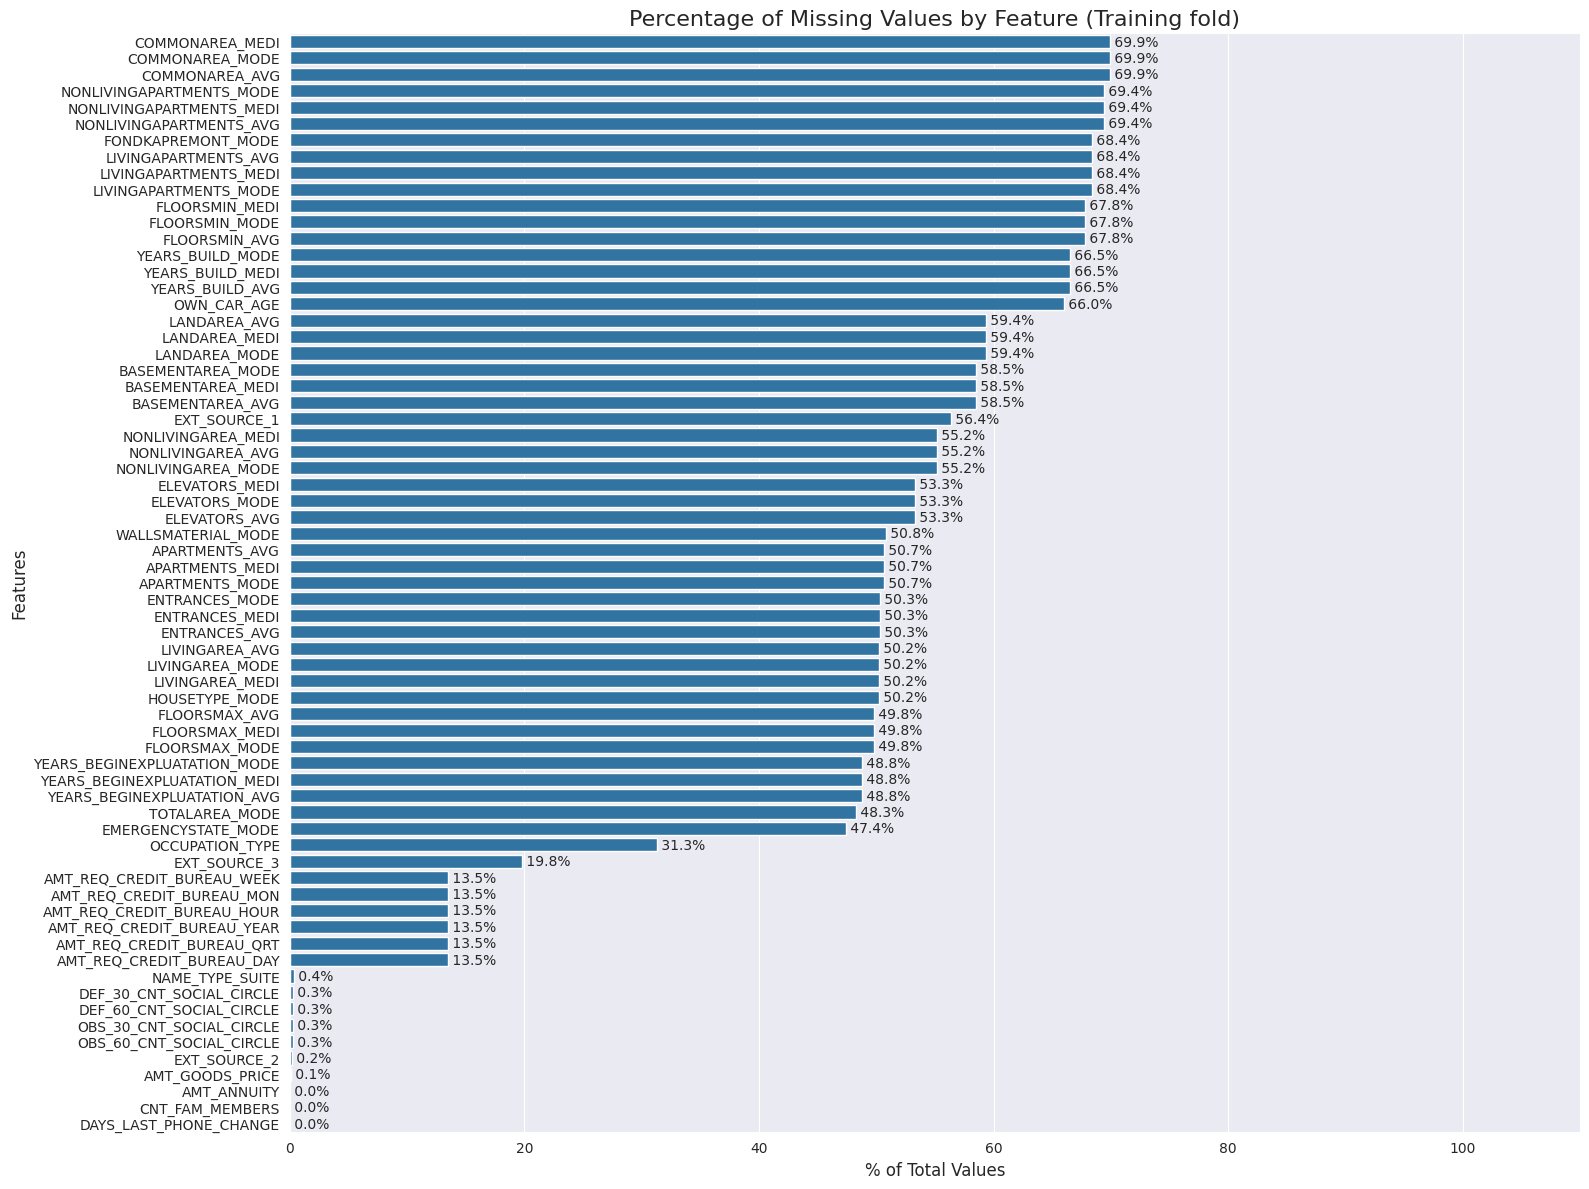

Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


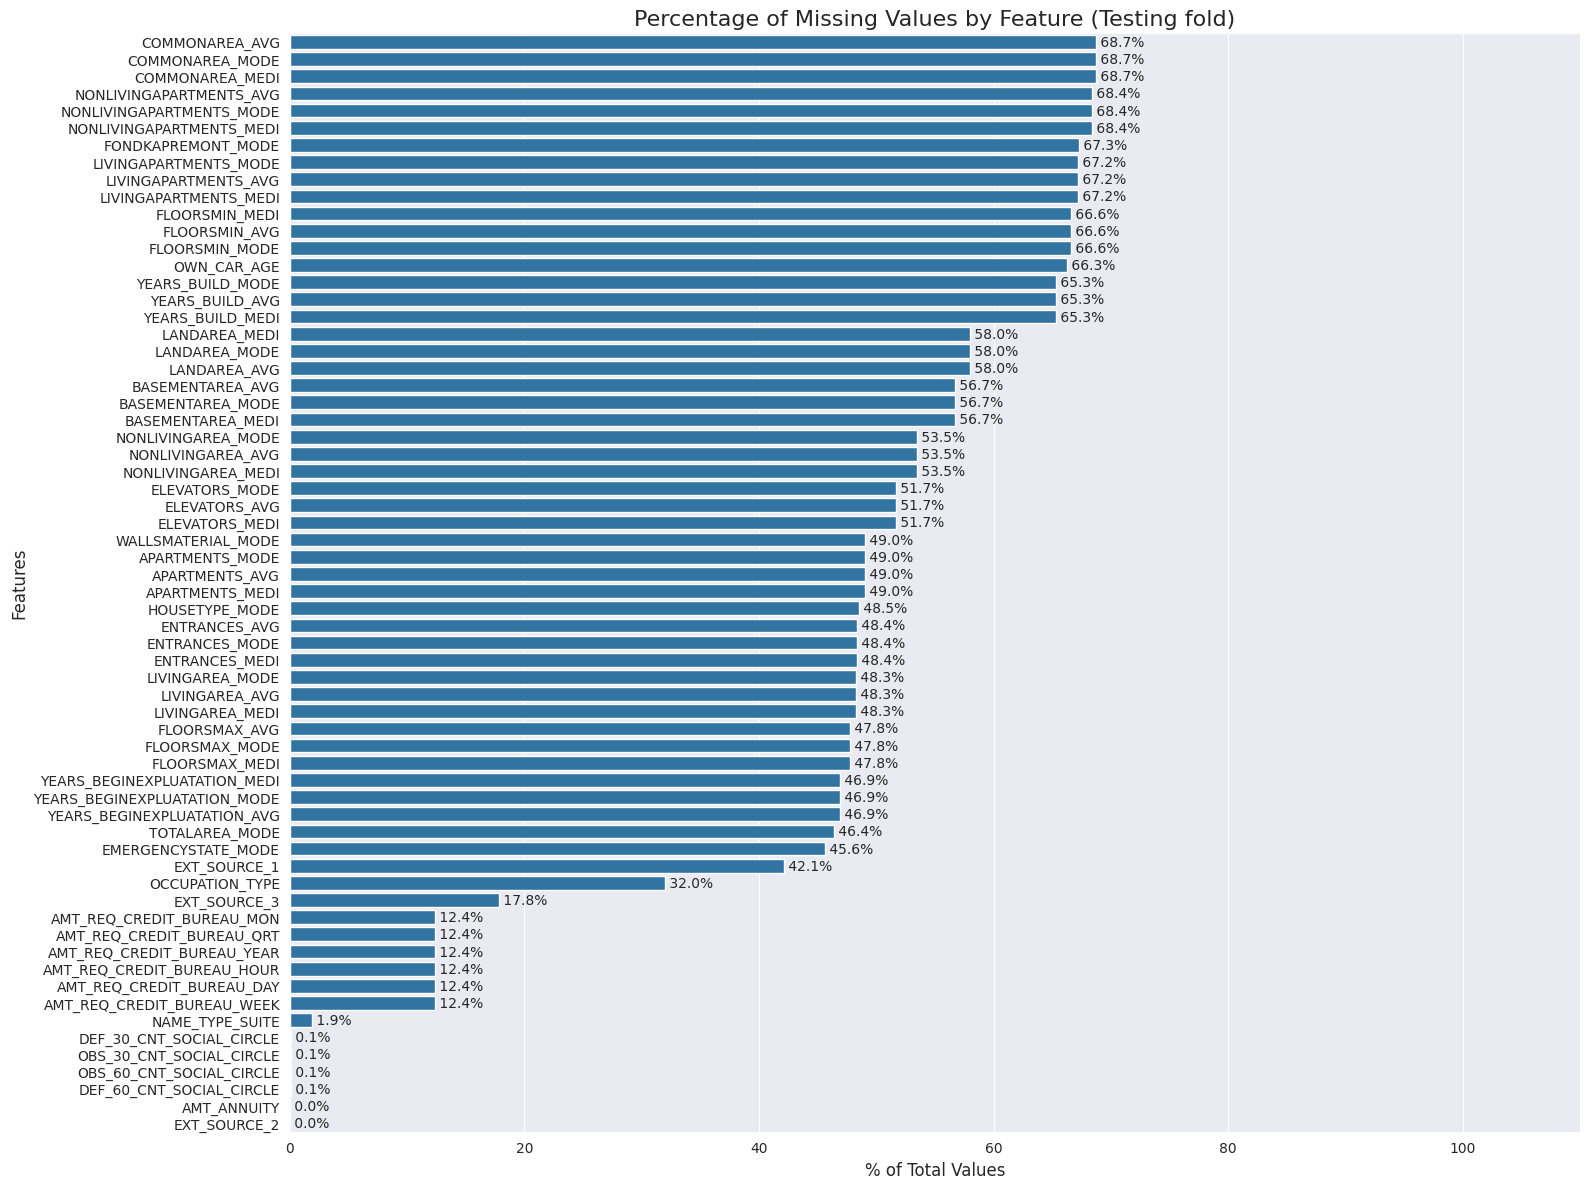

In [9]:
for fold in ('train', 'test'):
    missing_test_values = missing_values_table(get_dataset('application_' + fold + '.csv'))

    # TODO: Set the plot style for dark mode when exporting to png
    plt.figure(figsize=(16, 12))  # There are a lot of columns
    sns.barplot(x=missing_test_values['% of Total Values'], y=missing_test_values.index)
    plt.title(f'Percentage of Missing Values by Feature ({fold.title()}ing fold)', fontsize=16)
    plt.xlabel('% of Total Values', fontsize=12)
    plt.ylabel('Features', fontsize=12)

    # Add percentage text on the bars
    for index, value in enumerate(missing_test_values['% of Total Values']):
        plt.text(value, index, f' {value}%', va='center')

    plt.xlim(0, 110)  # Set x-limit to give space for text
    plt.tight_layout()
    plt.savefig('test.png')
    plt.show()

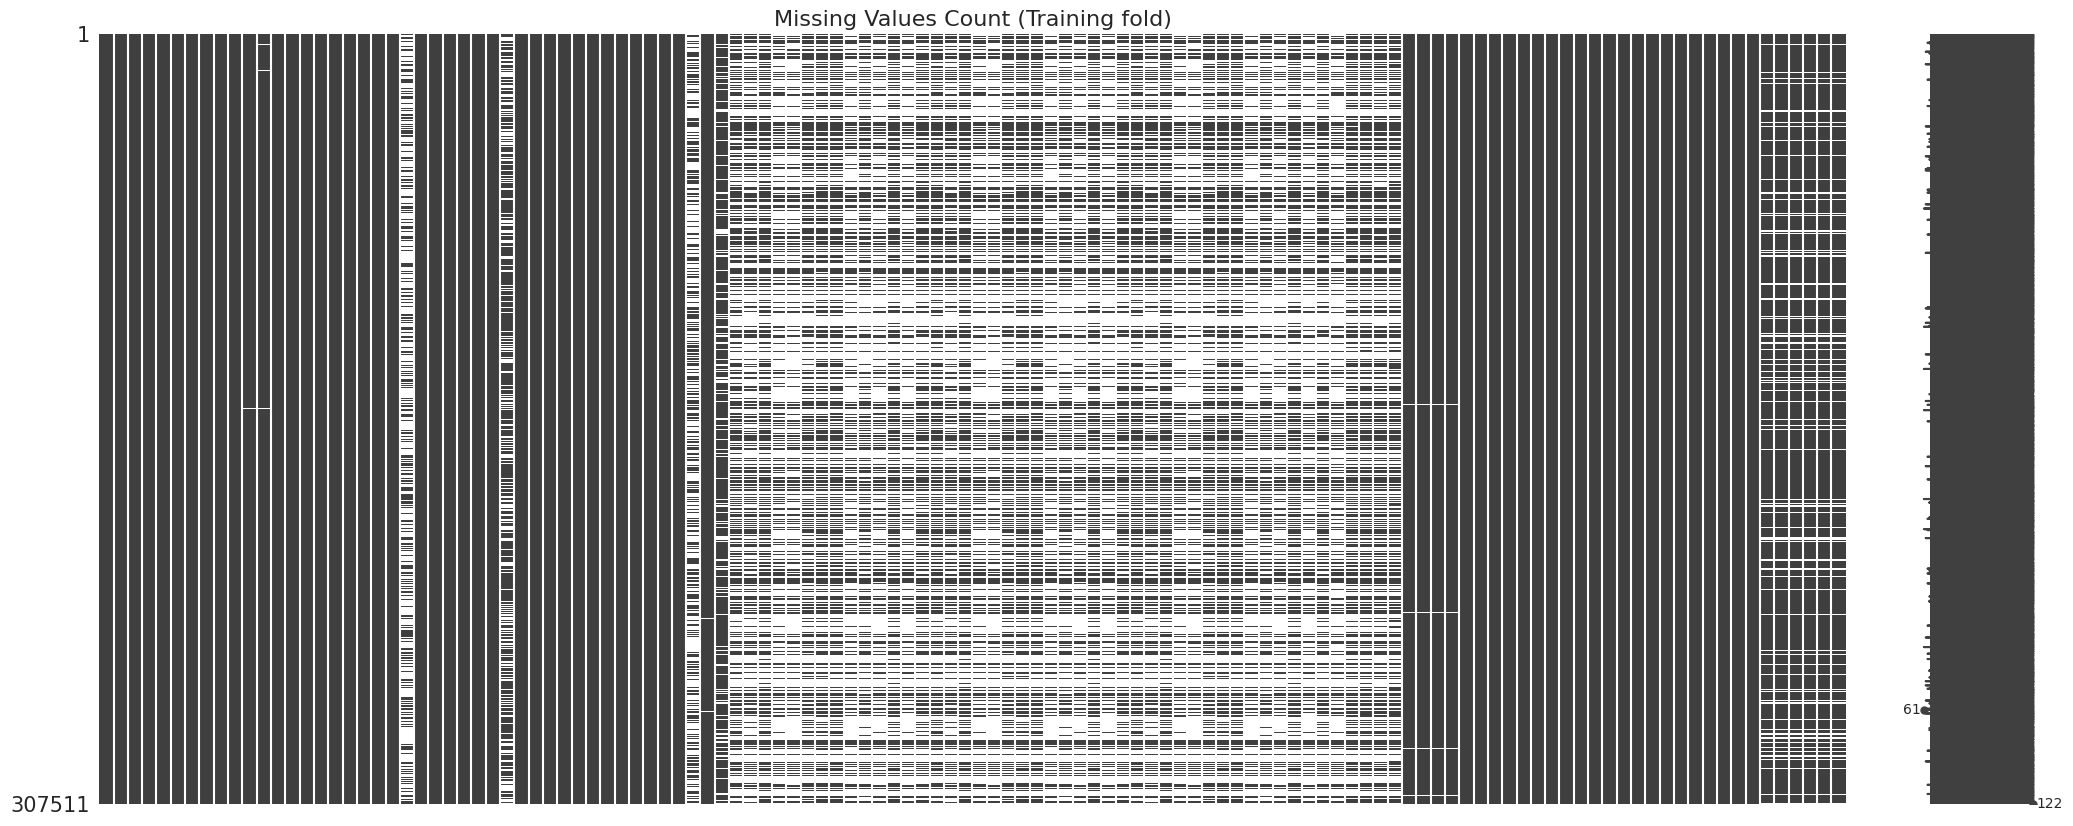

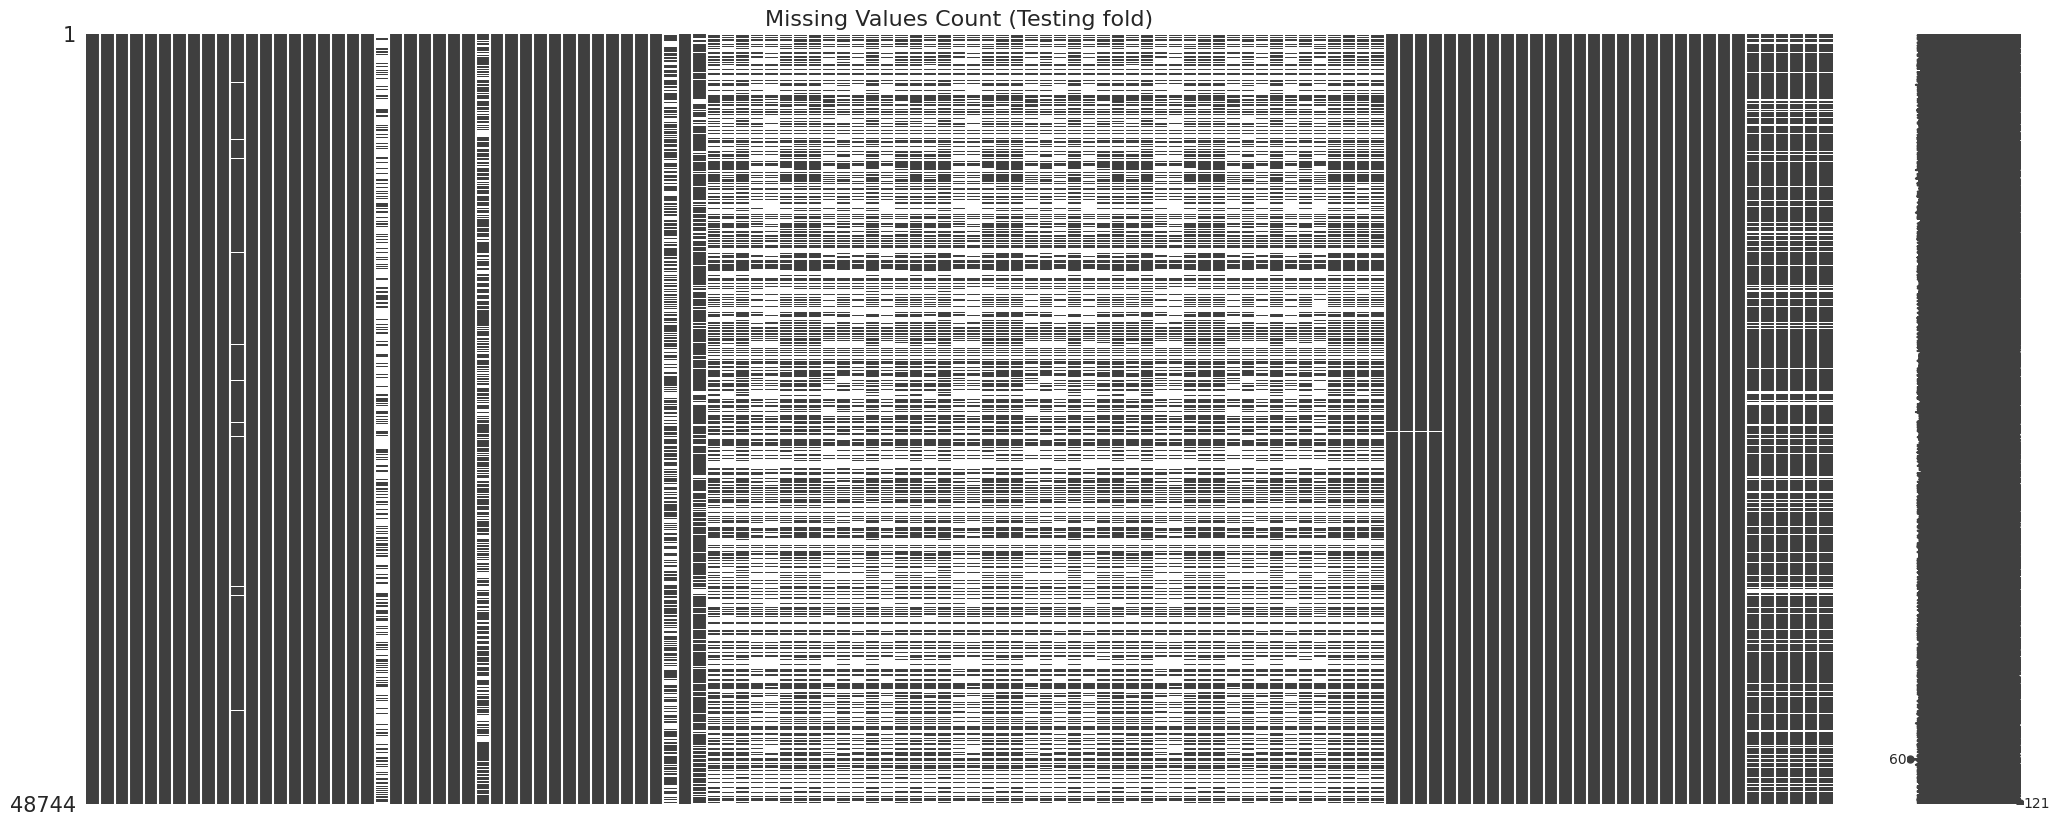

In [10]:
import missingno as msno

for fold in ('train', 'test'):
    msno.matrix(get_dataset('application_' + fold + '.csv'), fontsize=12)
    plt.title(f'Missing Values Count ({fold.title()}ing fold)', fontsize=16)
    plt.show()

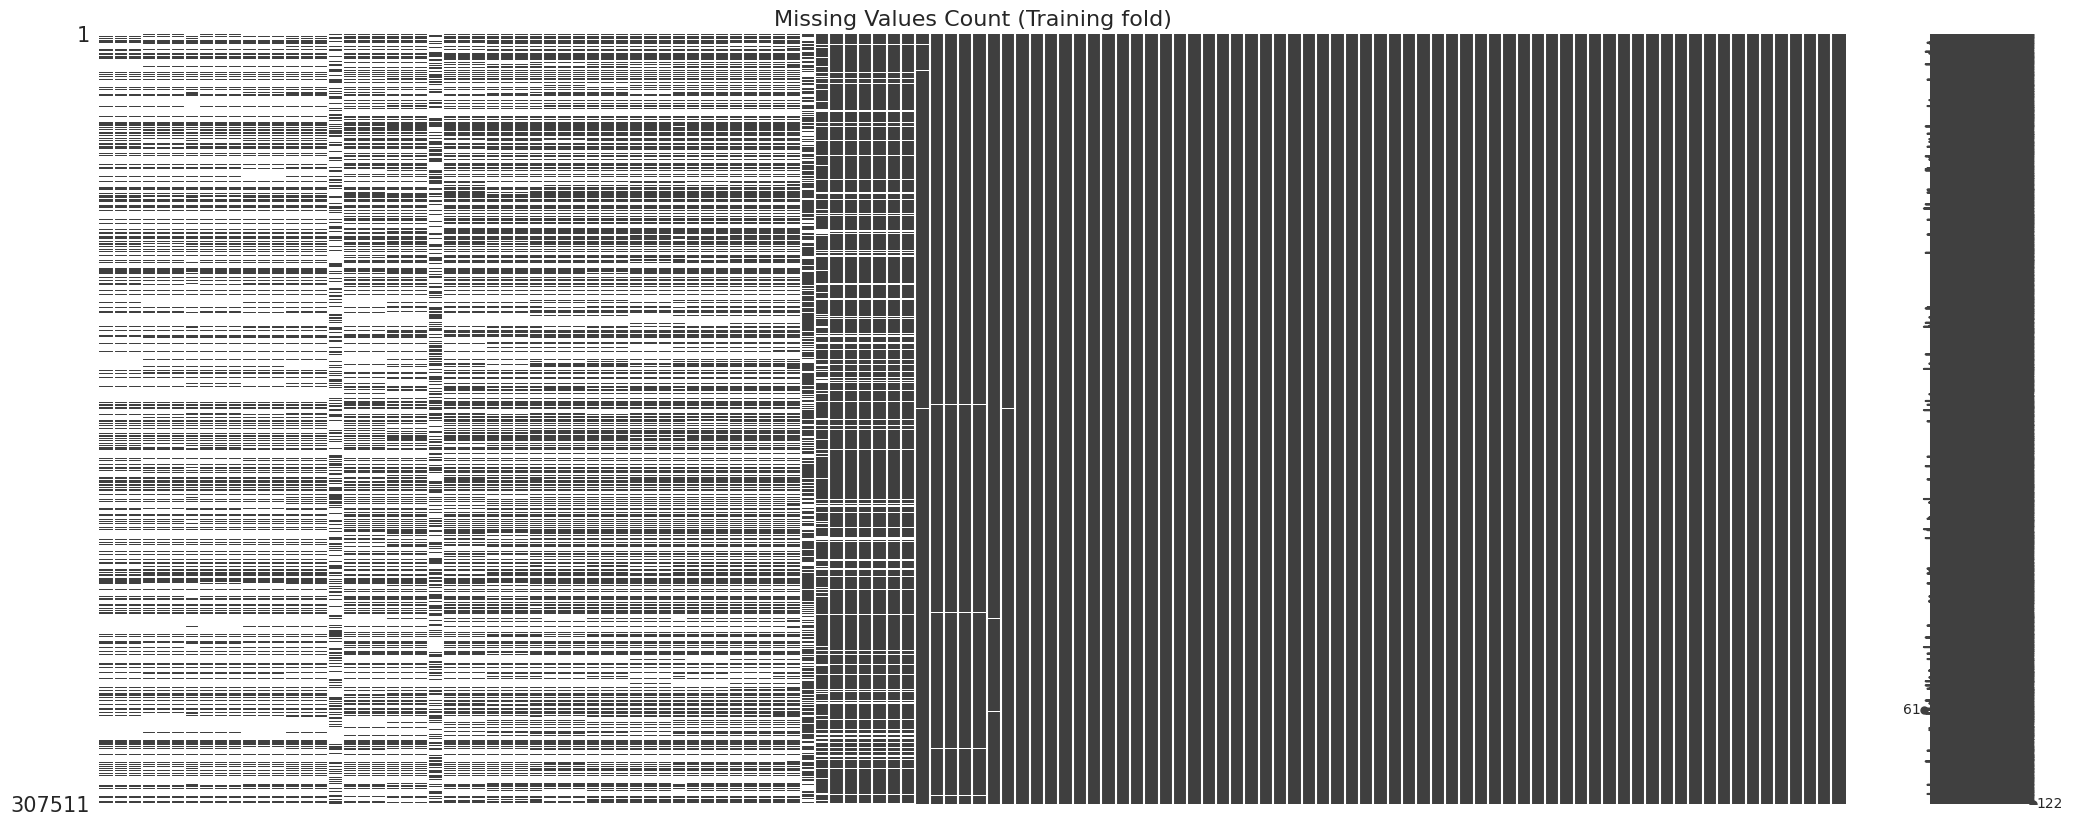

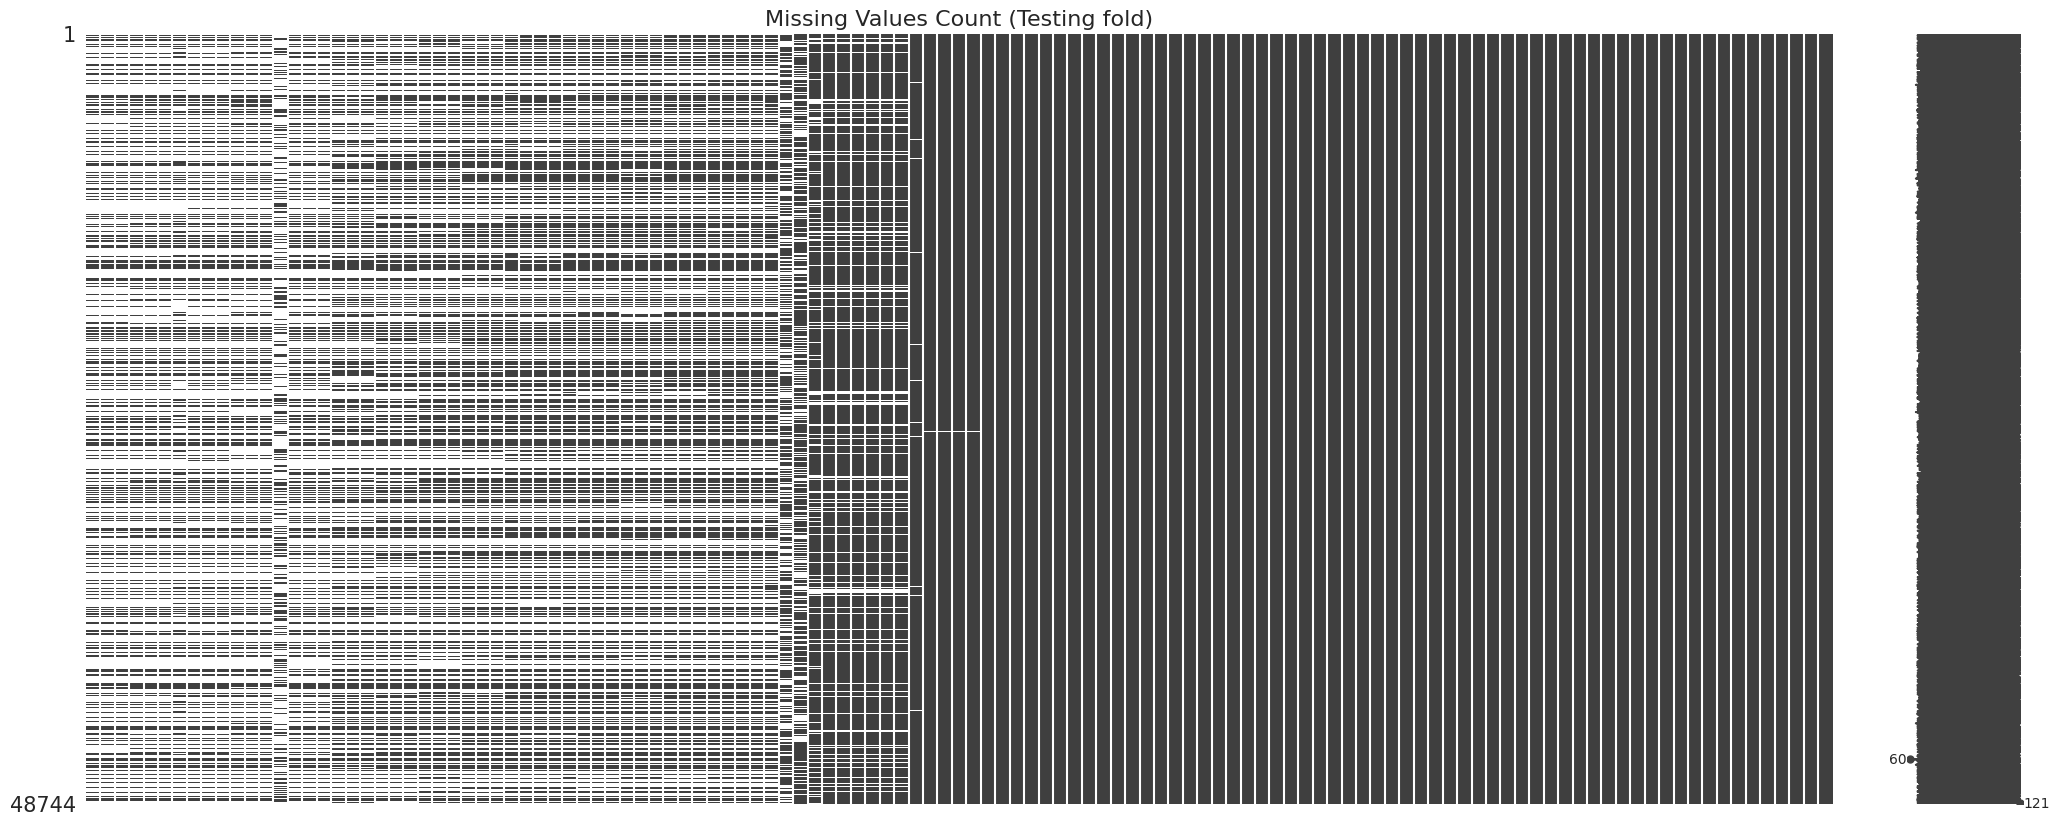

In [11]:
import missingno as msno

for fold in ('train', 'test'):
    df = get_dataset('application_' + fold + '.csv')
    msno.matrix(df[list(sorted(df.columns, key=(lambda col: int(df[col].notna().sum()))))], fontsize=12)
    plt.title(f'Missing Values Count ({fold.title()}ing fold)', fontsize=16)
    plt.show()

On peut voir ce qui a été montré précédemment, la moitié des colonnes ne possèdent aucunes valeurs manquantes, et le reste va grossièrement de 40 à 60 pourcent de valeurs manquantes

In [12]:
# TODO: The notebook suggests XGBoost to get away with the use of a dataset with missing values, I should probably look for all the models and split them into two groups, one that I will use first after filling the voids, and the second one that will get the unprocessed dataset, to see if the imputation adds or reduces accuracy

In [13]:
train_test_diff_col, = set(app_train) - set(app_test)
display(Markdown(f'La colonne **{train_test_diff_col!r}** est la seule à manquer du dataset de test'))

La colonne **'TARGET'** est la seule à manquer du dataset de test

In [14]:
assert not app_train.TARGET.isna().sum()
display(Markdown('Il ne manque aucune target'))

Il ne manque aucune target

#### Types de données

Les colonnes étant communes entre train et test, je vais me contenter de voir les types des valeurs de training

TODO: Combiner les deux durant l'analyse, ou garder une séparation stricte?

In [15]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [16]:
app_train[app_train.columns[app_train.dtypes == 'float64']]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,202500.0,406597.5,24700.5,351000.0,0.018801,-3648.0,NaN,1.0,0.083037,0.262949,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1186.0,NaN,2.0,0.311267,0.622246,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67500.0,135000.0,6750.0,135000.0,0.010032,-4260.0,26.0,1.0,NaN,0.555912,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,135000.0,312682.5,29686.5,297000.0,0.008019,-9833.0,NaN,2.0,NaN,0.650442,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,121500.0,513000.0,21865.5,513000.0,0.028663,-4311.0,NaN,1.0,NaN,0.322738,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,157500.0,254700.0,27558.0,225000.0,0.032561,-8456.0,NaN,1.0,0.145570,0.681632,...,0.0,0.0,0.0,-273.0,NaN,NaN,NaN,NaN,NaN,NaN
307507,72000.0,269550.0,12001.5,225000.0,0.025164,-4388.0,NaN,1.0,NaN,0.115992,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
307508,153000.0,677664.0,29979.0,585000.0,0.005002,-6737.0,NaN,1.0,0.744026,0.535722,...,0.0,6.0,0.0,-1909.0,1.0,0.0,0.0,1.0,0.0,1.0
307509,171000.0,370107.0,20205.0,319500.0,0.005313,-2562.0,NaN,2.0,NaN,0.514163,...,0.0,0.0,0.0,-322.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
app_train[app_train.columns[app_train.dtypes == 'int64']]

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,0,-9461,-637,-2120,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,-16765,-1188,-291,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,0,-19046,-225,-2531,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,-19005,-3039,-2437,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,-19932,-3038,-3458,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,-9327,-236,-1982,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,0,-20775,365243,-4090,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
307508,456253,0,0,-14966,-7921,-5150,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,0,-11961,-4786,-931,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


Le type objet peut être associée avec une colonne numérique possédant quelques valeurs invalides, il est donc important de m'assurer que ce n'est pas le cas ici

In [18]:
app_train[app_train.columns[app_train.dtypes == 'object']]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services,reg oper account,block of flats,"Stone, brick",No
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,MONDAY,XNA,reg oper account,block of flats,"Stone, brick",No
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School,reg oper account,block of flats,Panel,No
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,NaN,block of flats,"Stone, brick",No


In [19]:
app_train[app_train.columns[app_train.dtypes == 'object']].value_counts()

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE            NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  OCCUPATION_TYPE     WEEKDAY_APPR_PROCESS_START  ORGANIZATION_TYPE       FONDKAPREMONT_MODE     HOUSETYPE_MODE  WALLSMATERIAL_MODE  EMERGENCYSTATE_MODE
Cash loans          F            N             Y                Unaccompanied    Working           Secondary / secondary special  Married             House / apartment  Sales staff         TUESDAY                     Self-employed           reg oper account       block of flats  Panel               No                     31
                                                                                                                                                                                             THURSDAY                    Self-employed           reg oper account       block of flats  Panel               No                     23
                            

In [20]:
pd.DataFrame(
    data=[[col_name, len(app_train[col_name].unique())] for col_name in
          app_train.columns[app_train.dtypes == 'object']],
    columns=['column', 'unique_count'])

,column,unique_count
0,NAME_CONTRACT_TYPE,2
1,CODE_GENDER,3
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
4,NAME_TYPE_SUITE,8
5,NAME_INCOME_TYPE,8
6,NAME_EDUCATION_TYPE,5
7,NAME_FAMILY_STATUS,6
8,NAME_HOUSING_TYPE,6
9,OCCUPATION_TYPE,19


In [47]:
train = get_dataset('application_train')

<Axes: ylabel='count'>

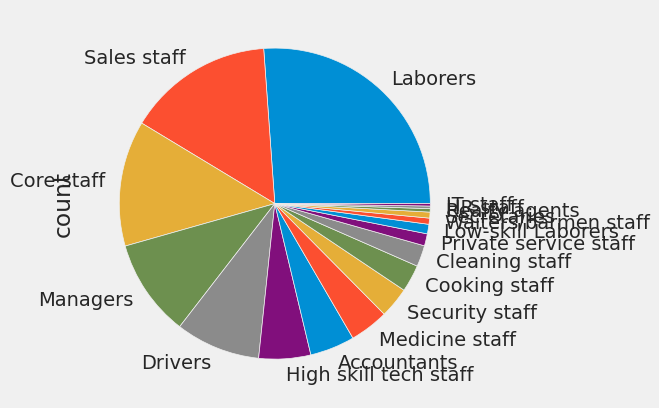

In [67]:
train.OCCUPATION_TYPE.value_counts().plot.pie()

##### Zoom sur les objets

Text(0, 0.5, 'Features')

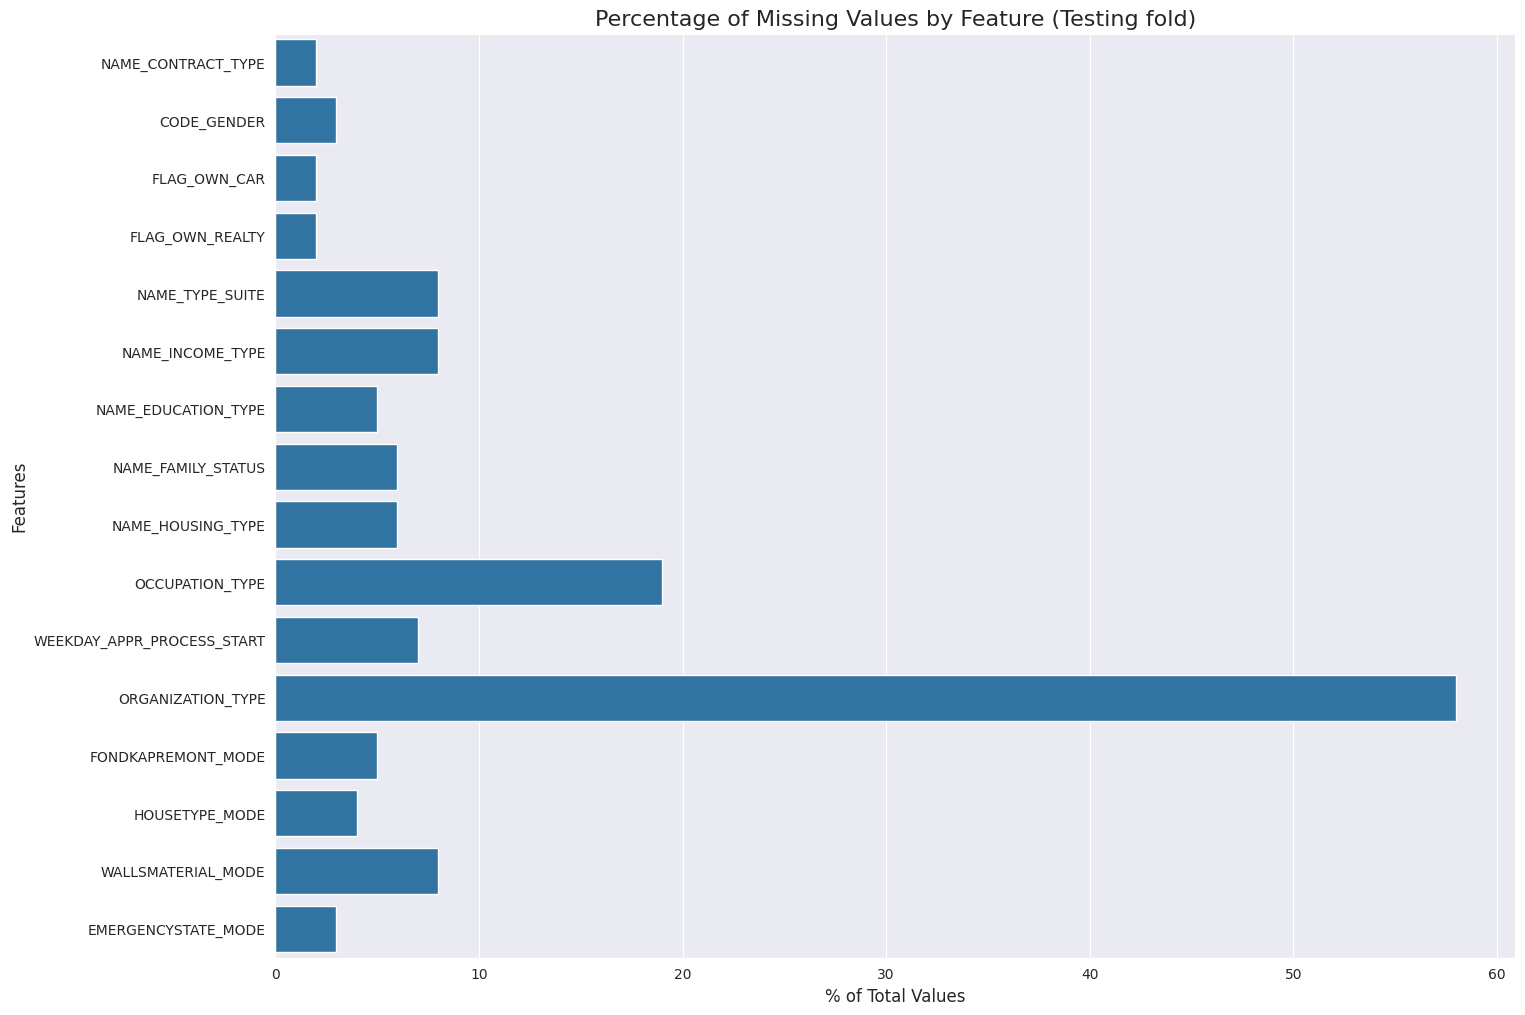

In [21]:
tmp = pd.DataFrame(
    data=[[col_name, len(app_train[col_name].unique())] for col_name in
          app_train.columns[app_train.dtypes == 'object']],
    columns=['column', 'unique_count'])
# TODO: Set the plot style for dark mode when exporting to png
plt.figure(figsize=(16, 12))  # There are a lot of columns
sns.barplot(x='unique_count', y='column', data=tmp)
plt.title(f'Percentage of Missing Values by Feature ({fold.title()}ing fold)', fontsize=16)
plt.xlabel('% of Total Values', fontsize=12)
plt.ylabel('Features', fontsize=12)


On peut voir relativement peu de types de valeurs textuelle, ce qui est bon si nous décitons d'utiliser des méthodes comme OneHot<br>

TODO: Voir s'il est possible de transformer les flags et booleans en int<br>
TODO: Voir s'il est possible de transformer les code gender -1 et 1 pour homme/femme et 0 pour XNA<br>
TODO: Voir d'autres algorithmes à utiliser pour transformer texte en nombre<br>
TODO: Voir la liste des algo supportant les données textuelles (je crois que RandomForest supporte)<br>
TODO: Should we do a PCA over the OneHot encoded organization type / occupation type?

In [22]:
assert not len(app_train.columns[
                   (app_train.dtypes != 'int64') &
                   (app_train.dtypes != 'float64') &
                   (app_train.dtypes != 'object')]), 'Plus de types de colonnes sont présentes'

In [23]:
num_train = app_train.copy()
num_test = app_test.copy()
del app_train, app_test

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in num_train:
    if num_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(num_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(num_train[col])
            # Transform both training and testing data
            num_train[col] = le.transform(num_train[col])
            num_test[col] = le.transform(num_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

# one-hot encoding of categorical variables
num_train = pd.get_dummies(num_train)
num_test = pd.get_dummies(num_test)

print('Training Features shape: ', num_train.shape)
print('Testing Features shape: ', num_test.shape)

print('%d columns were label encoded.' % le_count)

train_labels = num_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
num_train, num_test = num_train.align(num_test, join='inner', axis=1)

# Add the target back in
num_train['TARGET'] = train_labels

print('Training Features shape: ', num_train.shape)
print('Testing Features shape: ', num_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)
3 columns were label encoded.
Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [24]:
((num_train['DAYS_BIRTH'] / -365).describe()).to_frame().join(
    (num_test['DAYS_BIRTH'] / -365).describe(),
    lsuffix='_train',
    rsuffix='_test'
)

,DAYS_BIRTH_train,DAYS_BIRTH_test
count,307511.000000,48744.000000
mean,43.936973,44.022150
std,11.956133,11.851782
min,20.517808,20.104110
25%,34.008219,34.235616
50%,43.150685,43.246575
75%,53.923288,53.800000
max,69.120548,69.027397


TODO: Est-ce normal d'avoir la même chose?

In [25]:
((num_train['DAYS_BIRTH'] / -365).describe()).to_frame().reset_index()

,index,DAYS_BIRTH
0,count,307511.000000
1,mean,43.936973
2,std,11.956133
3,min,20.517808
4,25%,34.008219
5,50%,43.150685
6,75%,53.923288
7,max,69.120548


In [26]:
((num_test['DAYS_BIRTH'] / -365).describe()).to_frame().reset_index()

,index,DAYS_BIRTH
0,count,48744.000000
1,mean,44.022150
2,std,11.851782
3,min,20.104110
4,25%,34.235616
5,50%,43.246575
6,75%,53.800000
7,max,69.027397


In [27]:
((num_train['DAYS_EMPLOYED']).describe()).to_frame().join(
    (num_test['DAYS_EMPLOYED']).describe(),
    lsuffix='_train',
    rsuffix='_test'
)

,DAYS_EMPLOYED_train,DAYS_EMPLOYED_test
count,307511.000000,48744.000000
mean,63815.045904,67485.366322
std,141275.766519,144348.507136
min,-17912.000000,-17463.000000
25%,-2760.000000,-2910.000000
50%,-1213.000000,-1293.000000
75%,-289.000000,-296.000000
max,365243.000000,365243.000000


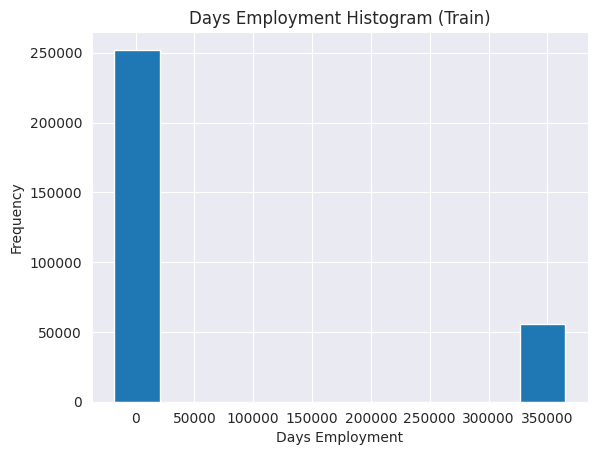

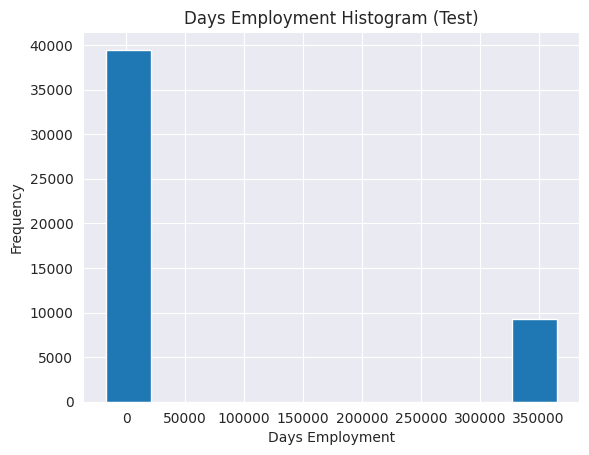

In [28]:
num_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram (Train)')
plt.xlabel('Days Employment')
plt.show()
num_test['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram (Test)')
plt.xlabel('Days Employment')
plt.show()

In [29]:
anom = num_train[num_train['DAYS_EMPLOYED'] == 365243]
non_anom = num_train[num_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


There are 9274 anomalies in the test data out of 48744 entries


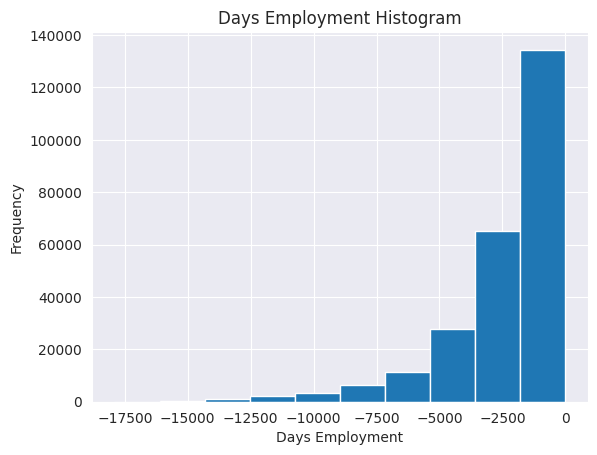

In [30]:
# TODO: Set a new name
app_train, app_test = num_train.copy(), num_test.copy()
del num_train, num_test

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)
print(
    'There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

In [31]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n')
correlations.tail(15)

Most Positive Correlations:



OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

In [32]:
print('\nMost Negative Correlations:\n')
correlations.head(15)


Most Negative Correlations:



EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
DAYS_EMPLOYED_ANOM                     -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
Name: TARGET, dtype: float64

In [33]:
# Find the correlation of the positive days since birth and target
assert (app_train['DAYS_BIRTH'] > 0).sum() == 0, (
    (app_train['DAYS_BIRTH'] < 0).sum())
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

np.float64(0.07823930830982694)

This is the most correlated to the target.
The days birth being negative, a positive corellation means that young people are less likely to repay on time

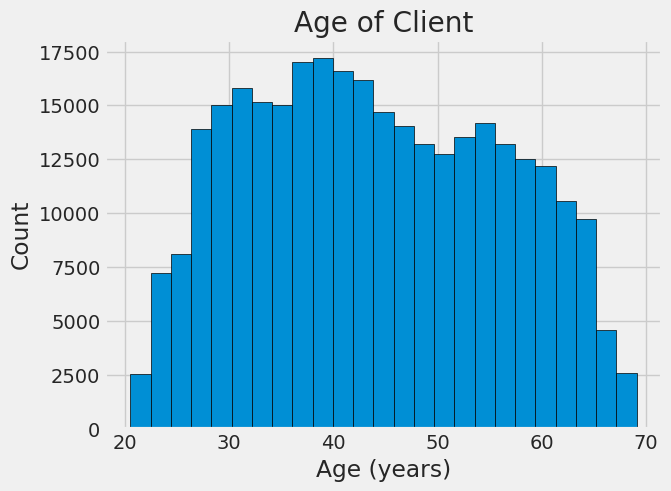

In [34]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / -365, edgecolor='k', bins=25)
plt.title('Age of Client');
plt.xlabel('Age (years)');
plt.ylabel('Count');

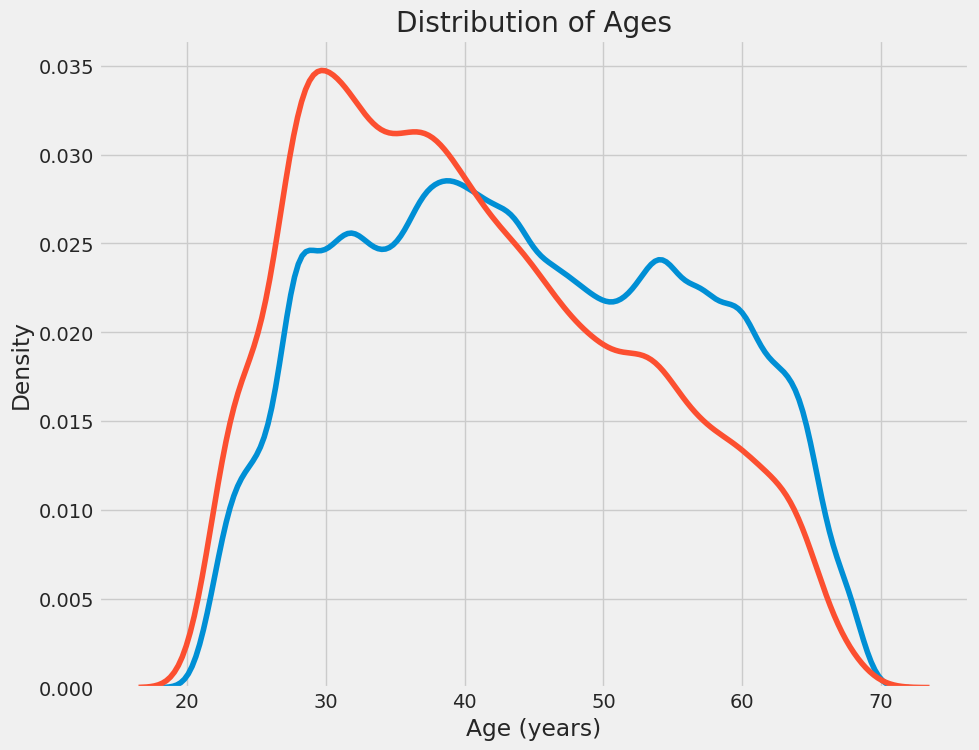

In [35]:
plt.figure(figsize=(10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label='target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label='target == 1')

# Labeling of plot
plt.xlabel('Age (years)');
plt.ylabel('Density');
plt.title('Distribution of Ages');

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,-9461,25.920548,"(24.762, 27.143]"
1,0,-16765,45.931507,"(43.81, 46.19]"
2,0,-19046,52.180822,"(50.952, 53.333]"
3,0,-19005,52.068493,"(50.952, 53.333]"
4,0,-19932,54.608219,"(53.333, 55.714]"


,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 22.381]",0.129711,-7963.408414,21.817557
"(22.381, 24.762]",0.122442,-8618.057342,23.611116
"(24.762, 27.143]",0.106379,-9500.634941,26.029137
"(27.143, 29.524]",0.113599,-10329.179104,28.299121
"(29.524, 31.905]",0.109755,-11219.425660,30.738152
"(31.905, 34.286]",0.097782,-12073.027138,33.076787
"(34.286, 36.667]",0.098144,-12957.672767,35.500473
"(36.667, 39.048]",0.088109,-13819.122612,37.860610
"(39.048, 41.429]",0.080671,-14682.749842,40.226712


Text(0.5, 1.0, 'Failure to Repay by Age Group')

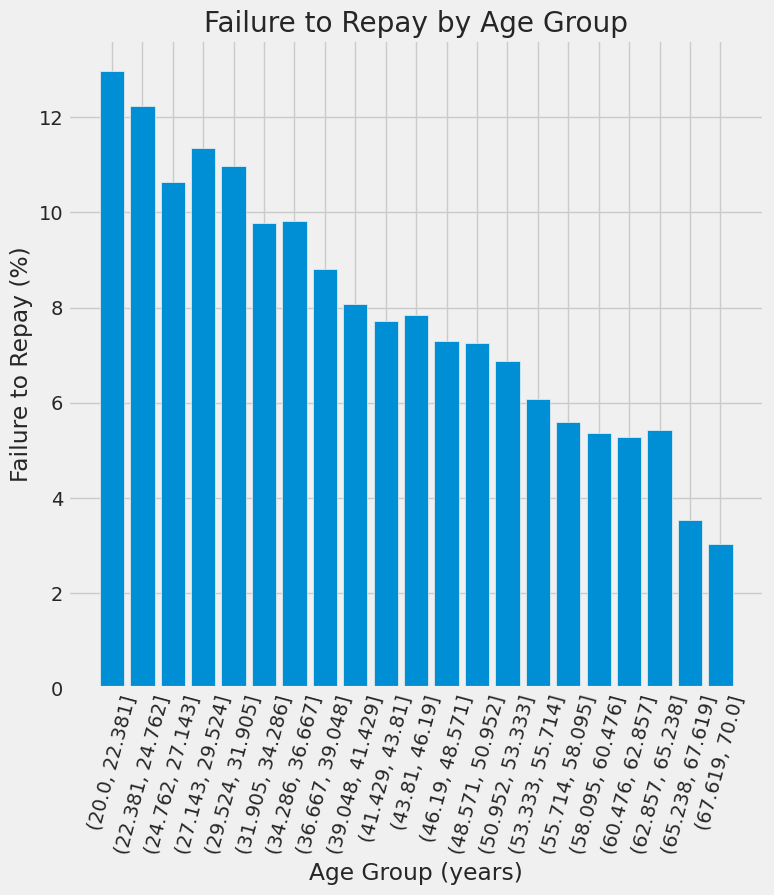

In [36]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=22))
display(age_data.head(5))

# Group by the bin and calculate averages
age_groups = age_data.groupby('YEARS_BINNED').mean()
display(age_groups)

plt.figure(figsize=(8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation=75);
plt.xlabel('Age Group (years)');
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

In [37]:
# Extract the EXT_SOURCE variables and show correlations, as those are the three least correlated
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


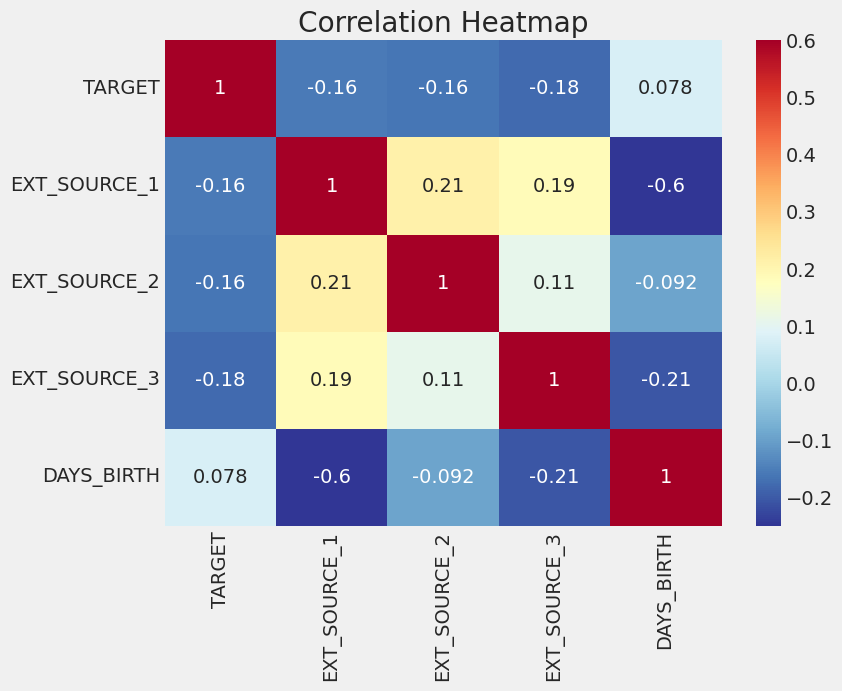

In [38]:
plt.figure(figsize=(8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap');

The biggest correlation is between the first external source and the age

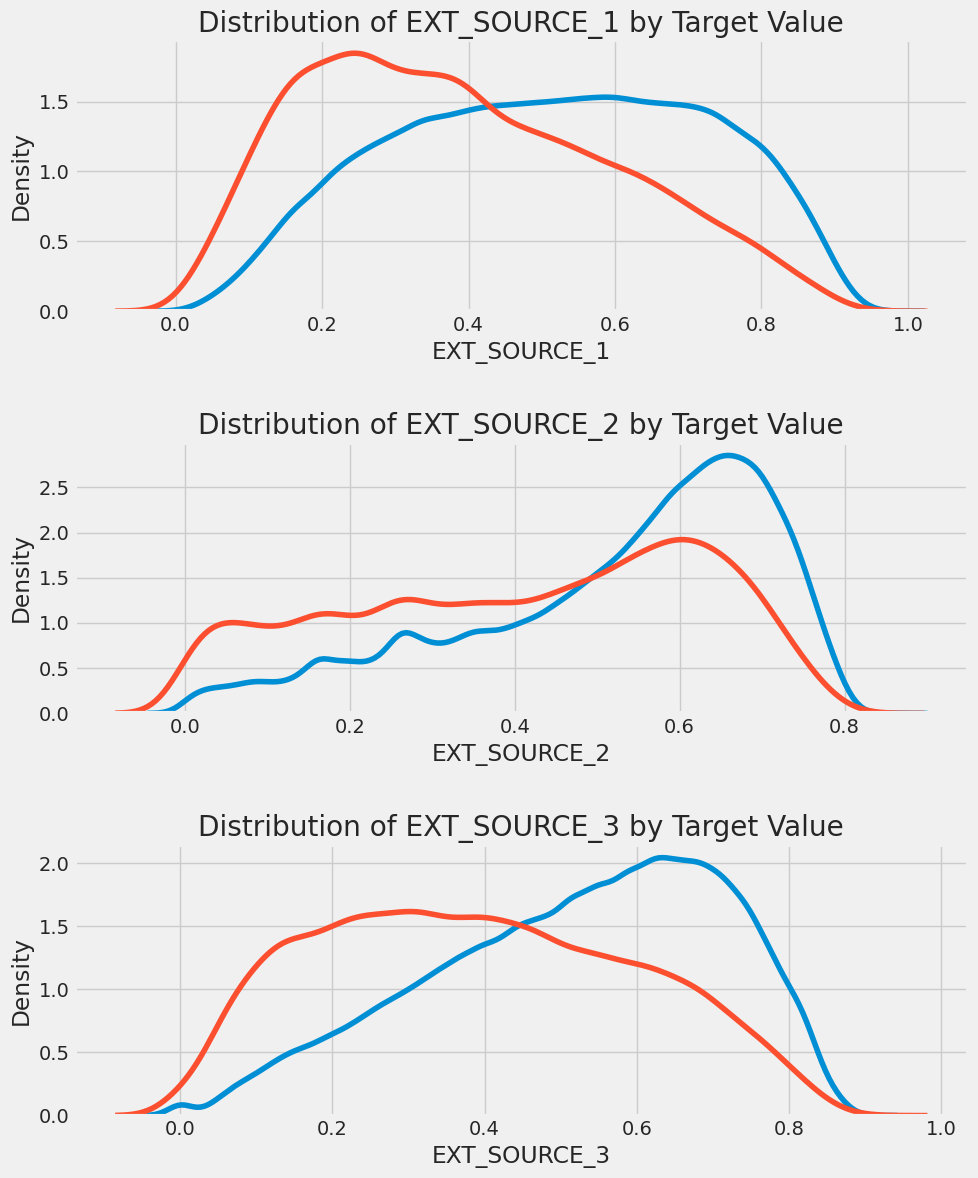

In [39]:
plt.figure(figsize=(10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label='target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label='target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source);
    plt.ylabel('Density');

plt.tight_layout(h_pad=2.5)


All are weak according to the most common interpretation of the pearson coefficient

- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

Text(0.5, 1.05, 'Ext Source and Age Features Pairs Plot')

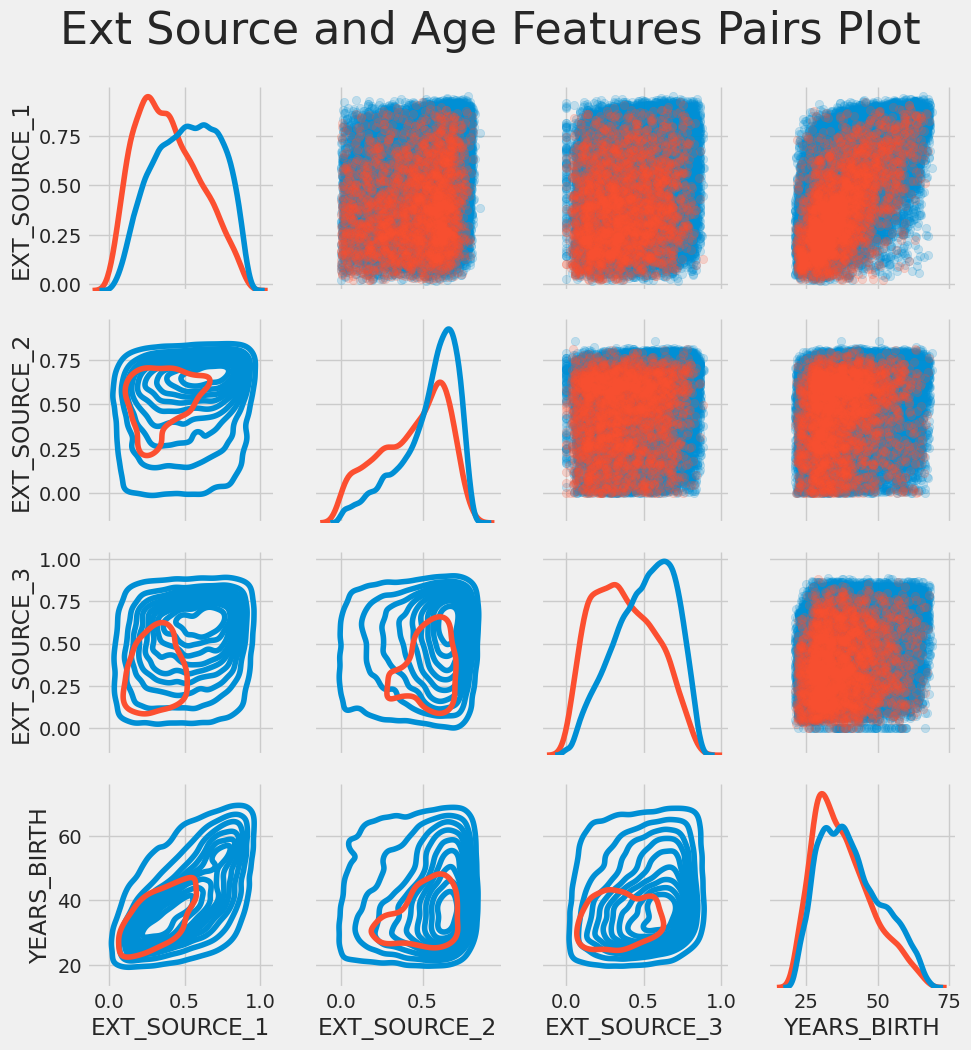

In [40]:
# Copy the data for plotting
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]


# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size=20)


# Create the pairgrid object
grid = sns.PairGrid(data=plot_data, diag_sharey=False,
                    hue='TARGET',
                    vars=[x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha=0.2)

# This forces the old behavior, scaling each curve independently
grid.map_diag(sns.kdeplot, common_norm=False)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)

In [41]:
app_train.head().to_csv()

',SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIV

# Data Leakage

On a vu plus tôt une très faible corrélation entre les variables et la TARGET.<br>
Un risque possible serai d'avoir une variable d'entrée définies après l'emprunt<br>
Cependant les variables EXT_SOURCE_x sont opaques
Et les colonnes *_SOCIAL_CIRCLE peuvent ne pas avoir été prises assez tôt

In [42]:
app_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,False,True,False,True,False,1,False
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,False,False,False,False,False,False,True,False,0,False
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,False,False,False,False,False,0,False
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,False,False,False,False,False,False,False,0,False
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,False,False,False,False,False,False,False,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,False,False,False,False,True,False,True,False,0,False
307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,False,False,False,False,True,False,True,False,0,True
307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,False,False,False,True,False,False,True,False,0,False
307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,...,False,False,False,False,True,False,True,False,1,False
